In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [3]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)

In [4]:
# Scale Data

from sklearn.preprocessing import StandardScaler
numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)
scaled_data.shape

(129, 102)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.001s...
[t-SNE] Computed neighbors for 129 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 5.443259
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.292046
[t-SNE] KL divergence after 300 iterations: 0.296526


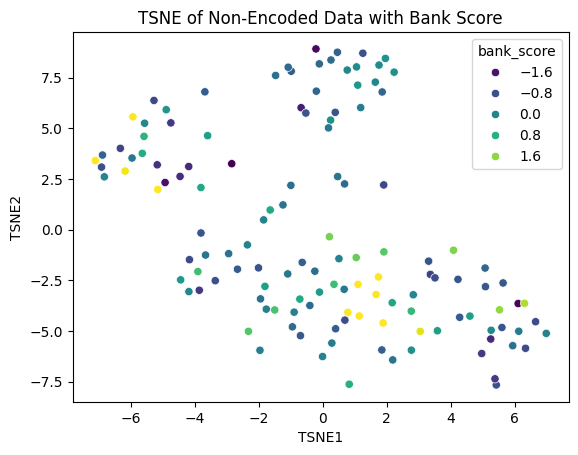

In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['Pop2010'] - df['PovertyRate']
q1 = score.quantile(0.25)
q3 = score.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
score = score.clip(lower, upper)
tsne_df['bank_score'] = (score - score.mean()) / score.std()

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Non-Encoded Data with Bank Score")
# plt.savefig('images/clustering.png')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 5.443259
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.717693
[t-SNE] KL divergence after 300 iterations: 0.250776


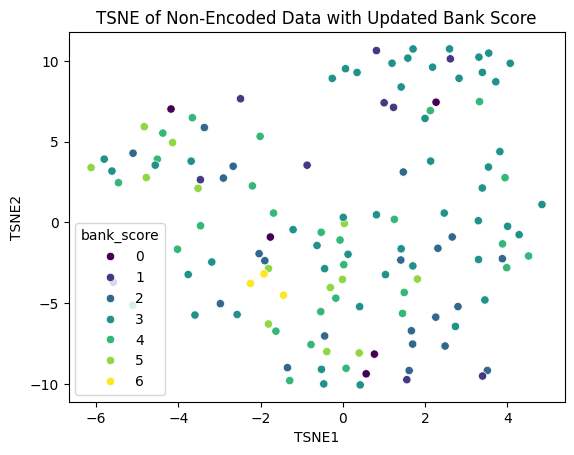

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(scaled_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
tsne_df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Non-Encoded Data with Updated Bank Score")
# plt.savefig('images/clustering.png')
plt.show()

In [7]:
# Use Autoencoder to reduce dimensionality
num_dimensions = 10

encoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu"),
    keras.layers.Dense(num_dimensions, activation="selu")
])

decoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu", input_shape=[num_dimensions]),
    keras.layers.Dense(scaled_data.shape[1], activation="selu")
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(scaled_data, scaled_data, epochs=1000, validation_data=[scaled_data, scaled_data])

Epoch 1/1000


2023-11-06 21:17:59.855918: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-06 21:17:59.855947: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-06 21:17:59.855959: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-06 21:17:59.856343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-06 21:17:59.856587: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-06 21:18:00.316668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 76ms/step - loss: 1.3989 - val_loss: 1.2531
Epoch 2/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.2272 - val_loss: 1.1641
Epoch 3/1000
5/5 [==============================] - 0s 25ms/step - loss: 1.1457 - val_loss: 1.0957
Epoch 4/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.0745 - val_loss: 1.0251
Epoch 5/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.0067 - val_loss: 0.9621
Epoch 6/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.9452 - val_loss: 0.9077
Epoch 7/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.8914 - val_loss: 0.8545
Epoch 8/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.8386 - val_loss: 0.7973
Epoch 9/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.7778 - val_loss: 0.7400
Epoch 10/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.7263 - val_loss: 0.6933
Epoch 11/1000
5/5 [===

In [8]:
encoded_data = encoder.predict(scaled_data)

5/5 [==============================] - 0s 3ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.491822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.164444
[t-SNE] KL divergence after 300 iterations: 0.268317


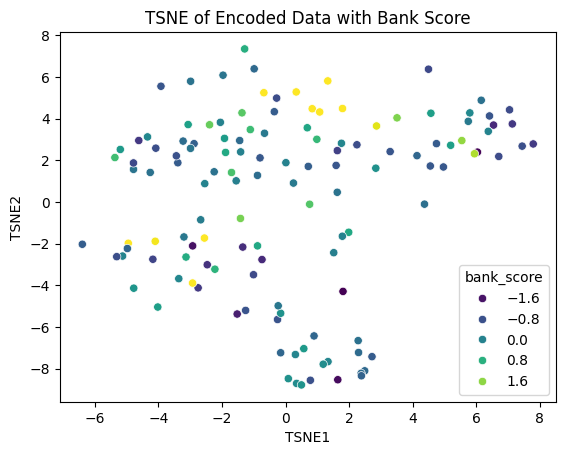

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(encoded_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['Pop2010'] - df['PovertyRate']
q1 = score.quantile(0.25)
q3 = score.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
score = score.clip(lower, upper)
tsne_df['bank_score'] = (score - score.mean()) / score.std()

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Encoded Data with Bank Score")
# plt.savefig('images/clustering.png')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.491822
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.134888
[t-SNE] KL divergence after 300 iterations: 0.323354


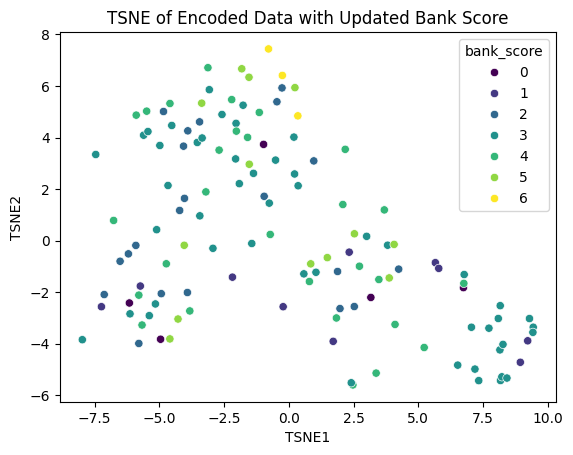

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(encoded_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
tsne_df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Encoded Data with Updated Bank Score")
# plt.savefig('images/clustering.png')
plt.show()